# NASDAQ Technical Analysis & Trends
Hypothesis<br>
which days are bullish and bearish?<br>
which months are bullish and bearish?<br> 

get nasdaque historical prices<br> 
store it in a database as we plan to add new features<br> 
retrieve from database and create new dataset<BR>
define new features such as day & month that will be used for seasonality <br> 
introduce moving averages <br> 
add some visizuliations<br> 
use Github<br> 




In [178]:
import psycopg2
from psycopg2 import sql
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt


### Source data from yahoo finance

In [179]:
# Nasadq composite ticker symbol
ticker = '^ixic'

# Fetch data for a ticker
df = yf.download(ticker, start='2024-01-01', end='2024-09-18')

[*********************100%%**********************]  1 of 1 completed


In [180]:
df.reset_index(inplace=True)
df['Ticker'] = ticker
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2024-01-02,14873.700195,14887.799805,14682.379883,14765.94043,14765.94043,5791170000,^ixic


### Connecting to PostgresSQL and loading into a dataframe called df_sql

In [181]:
# psycopg2 is a PostgreSQL database adapter for Python. It allows Python programs to interact with PostgreSQL databases.
# creating a varible to connect with the database.

conn = psycopg2.connect(
    dbname="Stocks",
    user="postgres",
    password="Araofooaca47@41",
    host="localhost",
    port="5432"
)
# Enable autocommit
conn.autocommit = True
cur = conn.cursor()    # The cursor allows python to interact with Postgres SQL database.

In [182]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)



C:\Users\rinde\AppData\Local\Temp\ipykernel_17276\3161469733.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


In [183]:
df_sql.head(1)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day
0,4706,14877.7,14998.2,14842.7,14969.65,14969.65,4.404590e+09,^ixic,2024-01-10,Wednesday,January,Up


In [184]:
# cur.execute('''
#     SELECT company_info.company, company_info.ticker, stock_symbol.high, stock_symbol.low, stock_symbol.volume
#     FROM company_info
#     INNER JOIN stock_symbol
#     ON company_info.ticker = stock_symbol.ticker;
#  ''')

# # Fetch all the results
# rows = cur.fetchall()

# # Print the results
# for i in rows:
#     print(i)

In [185]:
# df.tail()

In [186]:
# for _, r in df.iterrows():
#     insert_query = '''
#         INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date)
#         VALUES (%s, %s, %s, %s, %s, %s, %s,%s);
#         '''
#     cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date']))

# conn.commit()


In [187]:
# df = df.reset_index()

### Adding two new features called day and month derived from Date column

In [188]:
# Changing Date colum to a date type so we can derive into day and month
df['Date'] = pd.to_datetime(df['Date'])

# Adding a day column and month column to the dataset
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()


### Seasonality features based on day 

In [189]:
# Calculate up and down days
up_day = (df['Close'] > df['Close'].shift(1))
down_day = (df['Close'] < df['Close'].shift(1))
unch = (df['Close'] == df['Close'].shift(1))

In [190]:
# Adding new features to show Up, Down and Unchanged days
df.loc[up_day, 'UpDown_Day'] = "Up"
df.loc[down_day, 'UpDown_Day'] = "Down"
df.loc[unch, 'UpDown_Day'] = "Unchanged"
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,UpDown_Day
0,2024-01-02,14873.700195,14887.799805,14682.379883,14765.940430,14765.940430,5791170000,^ixic,Tuesday,January,NaN
1,2024-01-03,14641.469727,14694.580078,14577.440430,14592.209961,14592.209961,5449950000,^ixic,Wednesday,January,Down
2,2024-01-04,14532.230469,14632.769531,14504.780273,14510.299805,14510.299805,5289220000,^ixic,Thursday,January,Down
3,2024-01-05,14500.110352,14625.190430,14477.570312,14524.070312,14524.070312,5232820000,^ixic,Friday,January,Up
4,2024-01-08,14564.469727,14846.900391,14560.200195,14843.769531,14843.769531,6337770000,^ixic,Monday,January,Up


In [191]:
df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,UpDown_Day
178,2024-09-17,17707.019531,17781.740234,17544.640625,17628.060547,17628.060547,4959520000,^ixic,Tuesday,September,Up


### Adding new features columns, day, month & updown_day, into the postgres table stock_symbol.


In [192]:
columns_query = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'stock_symbol';
'''
cur.execute(columns_query)
columns = cur.fetchall()

In [193]:
print(columns)

[('id',), ('open',), ('high',), ('low',), ('close',), ('adj_close',), ('volume',), ('ticker',), ('date',), ('day',), ('month',), ('updown_day',)]


In [194]:
if ('day',) not in columns:
    cur.execute(
        '''
        ALTER TABLE "stock_symbol"
        ADD COLUMN "day" TEXT;
        '''
        )

In [195]:
if('month',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "month" TEXT;
    '''
    )

In [196]:
if('updown_day',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "updown_day" TEXT;
    '''
    )

### Adding data from df to postgresSQL along with new features

In [197]:
# Deleting all data from table so we can upload fresh data/
cur.execute('''DELETE FROM stock_symbol''')

In [198]:
# Iterating through the rows and inserting into table
for _, r in df.iterrows():
    insert_query = '''
        INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date, day, month, updown_day)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        '''
    cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'],  r['Day'], r['Month'], r['UpDown_Day']))

conn.commit()

In [199]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)
df_sql.head(1)

C:\Users\rinde\AppData\Local\Temp\ipykernel_17276\3908707936.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day
0,4879,14873.7,14887.8,14682.38,14765.94,14765.94,5.791170e+09,^ixic,2024-01-02,Tuesday,January,NaN


In [200]:
# # Export to CSV
# df_sql.to_excel(r'C:\Users\rinde\OneDrive\Desktop\stocks.xlsx')

In [201]:
# create chart with days of the week and the open and close day column

In [202]:
cur.close()
conn.close()

In [203]:
df_clean = df_sql.replace('NaN', 'Down')



In [204]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert 'day' column to a categorical variable with the specified order
df_clean['day'] = pd.Categorical(df_clean['day'], categories=day_order, ordered=True)

In [205]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvtDay = pd.pivot_table(df_clean, index='day', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtDay['% Up'] = (df_pvtDay['Up'] / df_pvtDay.sum(axis=1)) * 100

df_pvtDay.head()


updown_day,Down,Up,% Up
day,,,
Monday,11,22,66.666667
Tuesday,15,23,60.526316
Wednesday,17,19,52.777778
Thursday,17,19,52.777778
Friday,16,20,55.555556


In [206]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month' column in df_clean to a categorical variable with the correct month order
df_clean['month'] = pd.Categorical(df_clean['month'], categories=month_order, ordered=True)

In [207]:
# create pivote table and assign it to a new dataframe df_pvtMonth
df_pvtMonth = pd.pivot_table(df_clean, index='month', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtMonth['% Up'] = (df_pvtMonth['Up'] / df_pvtMonth.sum(axis=1)) * 100
df_pvtMonth.head()


updown_day,Down,Up,% Up
month,,,
January,8,13,61.904762
February,9,11,55.000000
March,10,10,50.000000
April,11,11,50.000000
May,11,11,50.000000


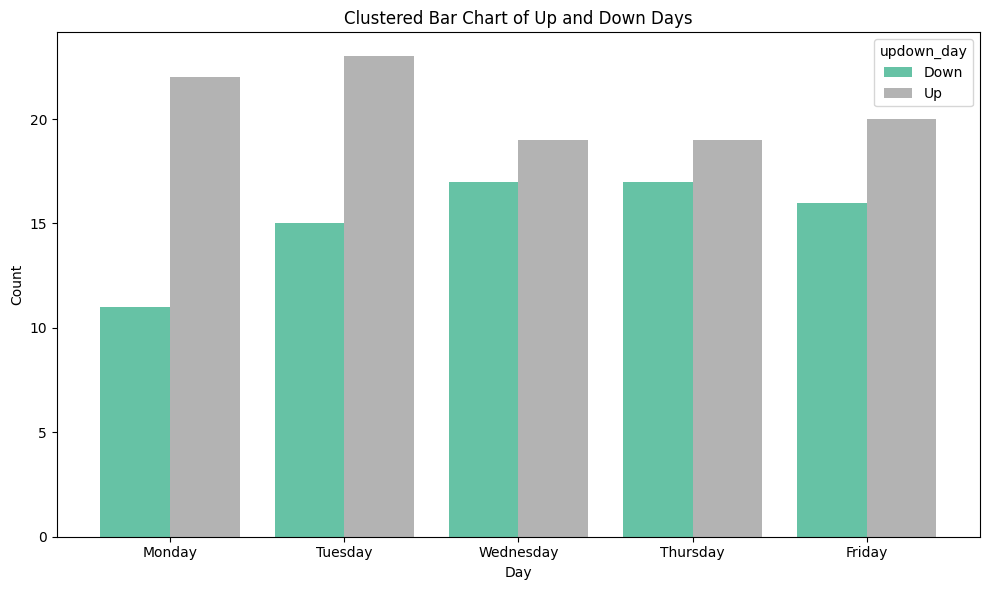

In [208]:
# Create cluster bar chart

# Drop the '% Up' column as we are interested in plotting the counts for 'Up' and 'Down'
df_pvtDay_plot = df_pvtDay.drop(columns='% Up')

# Plotting the pivot table as a clustered bar chart
df_pvtDay_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Bar Chart of Up and Down Days')
plt.xlabel('Day')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for better readability

# Show the plot
plt.tight_layout()
plt.show()

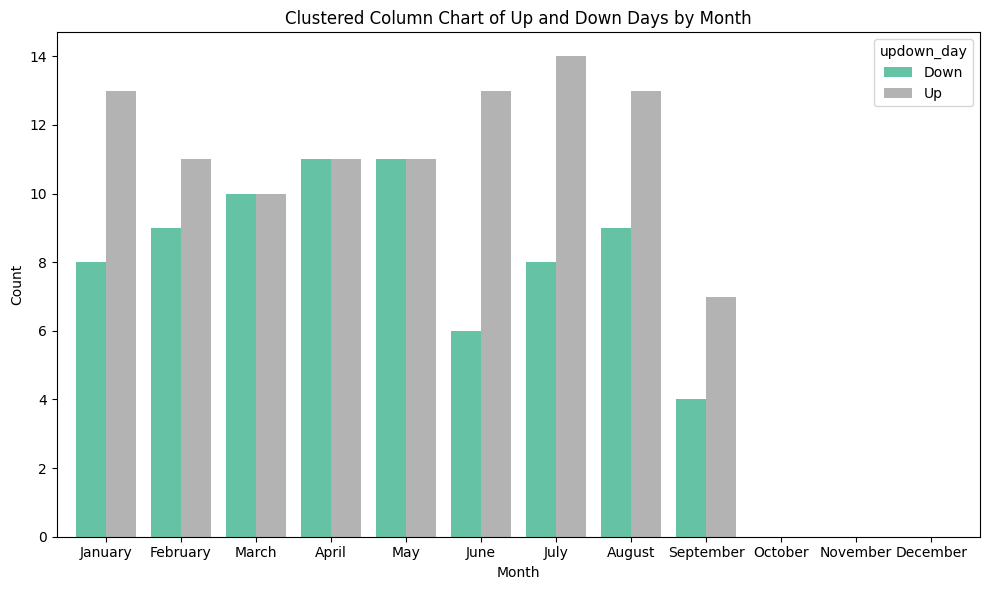

In [209]:
df_pvtMonth_plot = df_pvtMonth.drop(columns='% Up')

# Plot the pivot table as a clustered column chart (vertical bars)
df_pvtMonth_plot.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='Set2')

# Adding titles and labels
plt.title('Clustered Column Chart of Up and Down Days by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep month labels horizontal for better readability

# Show the plot
plt.tight_layout()  # Ensure the layout is nicely spaced
plt.show()

git checkout staging => switch between branches.<BR>
git fetch origin => update your local repository with the latest changes from the remote branch<BR>
git pull origin staging => Merge the remote staging branch into your local staging branch<BR>
git add . => add all changes in the current directory<BR>
git push origin staging